# Simulation results of events from $^{252}$Cf fission
For tunable $^{252}$Cf source activity

last edit Nov-23,2021

Events simulated by YuvalW

## definitions

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/TOFPET2/PETsysAnalysis/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
from PETsys_analysis_tools  import *;

%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [4]:
# data_path = '/Users/erezcohen/Desktop/Software/TOFPET2/PETsysAnalysis/Python/BoxSi/proto2.2/Geant4Simulations/YuvalSimulationResults/'
data_path = '/Users/erezcohen/Desktop/Software/TOFPET2/PETsysAnalysis/Python/BoxSi/proto2.2/Geant4Simulations/YuvalSimulationResults/my_simulations/'

## auxiliary functions

In [5]:
def merge_pulses(indices,times,window,energies,thresh):
    pulses=dict()
    times=np.array(list(map(float,times)))
    energies=np.array(list(map(float,energies)))
    indices=np.array(list(map(int,indices)))
    
    
    for i in range(N):
        pulses[i]=np.column_stack((times[indices==i], energies[indices==i]))
        pulses[i]=pulses[i][pulses[i][:,0].argsort()]

    
    for key in pulses.keys():
        temp_time=np.array([])
        temp_energy=np.array([])
        det_pulses=pulses[key]
        for i in range(det_pulses.shape[0]):
            if i==0:
                temp_time=np.append(temp_time,det_pulses[0,0])
                temp_energy=np.append(temp_energy,det_pulses[0,1])
            elif (det_pulses[i,0]-temp_time[-1])>window:
                temp_time=np.append(temp_time,det_pulses[i,0])
                temp_energy=np.append(temp_energy,det_pulses[i,1])
            else:
                temp_energy[-1]+=det_pulses[i,1]
        t_e_mat=np.column_stack((temp_time, temp_energy))
        pulses[key]=t_e_mat[t_e_mat[:,1]>thresh]
        
        """
        print(pulses[key])
        print("-----")
    print("-@@-@@-@@-@@-@@-")"""
    return pulses


## load data

In [6]:
N=4
c_names=["Time Gamma","Energy Gamma", "Id Gamma","Time Neutron","Energy Neutron","Id Neutron"]
df = pd.read_csv(data_path + 'rossi_nt_rossi.csv',sep=',',   header=9, names=c_names)

In [7]:
df["Time Neutron"]

0                                               4.58819e-09
1                                   1.19621e-09;1.30498e-09
2                       5.54608e-09;1.16228e-08;1.28335e-08
3                                               2.01635e-09
4                                                       NaN
                                ...                        
107390                                                  NaN
107391                                                  NaN
107392                   4.15196e-09;5.08865e-09;2.8606e-08
107393    1.94572e-09;5.70891e-09;6.62307e-09;6.83711e-0...
107394    4.54664e-09;6.09019e-09;6.10297e-09;7.51963e-0...
Name: Time Neutron, Length: 107395, dtype: object

## Simulate and plot Rossi-$\alpha$

### define source activity and detection threshold for $\gamma$ and $n$

In [8]:
particles_names=["Gamma","Neutron"]
energy_threshold=[0.4, 0.4*6] #Energy Threshold for Gamma detection and for Neutron Detection in MeV
window = 1e-9 #Time Window. The code merges each pair of pulses that the separtion in time between them is smaller than this value
rate   = 595500 #rate of fission events per second
t_global=0;

### produce pule train

In [9]:
final_pulses_times = np.array([])
final_pulses_energy= np.array([])
final_pulses_id    = np.array([])
final_pulses_isN   = np.array([])
for i in range(df.shape[0]):
    t_global+=np.random.exponential(1/rate);

    for particle_i in range(0,2):
        particle_name=particles_names[particle_i]
        row=df.iloc[i]
        time=row["Time "+particle_name]
        if isinstance(time,str):
            energy=row["Energy "+particle_name].split(";")
            det_index=row["Id "+particle_name].split(";")
            time=row["Time "+particle_name].split(";")
            final_pulses=merge_pulses(det_index,time,window,energy,energy_threshold[particle_i])

            for key, item in final_pulses.items():
                if (item.size>0):
                    time_row=item[:,0]+t_global
                    final_pulses_times=np.concatenate([final_pulses_times,time_row])
                    final_pulses_energy=np.concatenate([final_pulses_energy,item[:,1]])
                    final_pulses_id=np.concatenate([final_pulses_id,key*np.ones(time_row.size)])
                    final_pulses_isN=np.concatenate([final_pulses_isN,(particle_name=="Neutron")*np.ones(time_row.size)])

final_pulses_times=final_pulses_times*1e9 #to ns

titles=["Time (ns)","Energy(MeV)","Detector ID", "IsNeutron"]
df_final=pd.DataFrame(np.column_stack((final_pulses_times,final_pulses_energy,final_pulses_id,final_pulses_isN)),columns=titles)
df_final=df_final.sort_values(by="Time (ns)")
df_final.to_csv("pulse_train.csv")

In [10]:
df_final
# df_final["Time(ns)"]

,Time (ns),Energy(MeV),Detector ID,IsNeutron
0,6.969106e+02,4.125117,0.0,1.0
1,8.256999e+03,0.622672,3.0,0.0
2,9.033445e+03,4.152340,3.0,1.0
3,1.069716e+04,1.319125,0.0,0.0
4,1.125348e+04,2.435770,1.0,0.0
...,...,...,...,...
30698,1.809840e+08,0.953672,3.0,0.0
30699,1.809851e+08,0.590880,1.0,0.0
30700,1.809893e+08,0.757488,1.0,0.0
30701,1.809995e+08,0.597835,1.0,0.0


### create time-differences array
This takes a very long time...

In [12]:
t_arr = np.array(df_final["Time (ns)"])
t_diff = []
for i in range(len(t_arr)):
    t_diff_i = t_arr[i+1:]-t_arr[i]
    t_diff = np.concatenate([t_diff,t_diff_i])
print('done creating time differences array of length %d.'%len(t_diff))

KeyboardInterrupt: 

### plot results

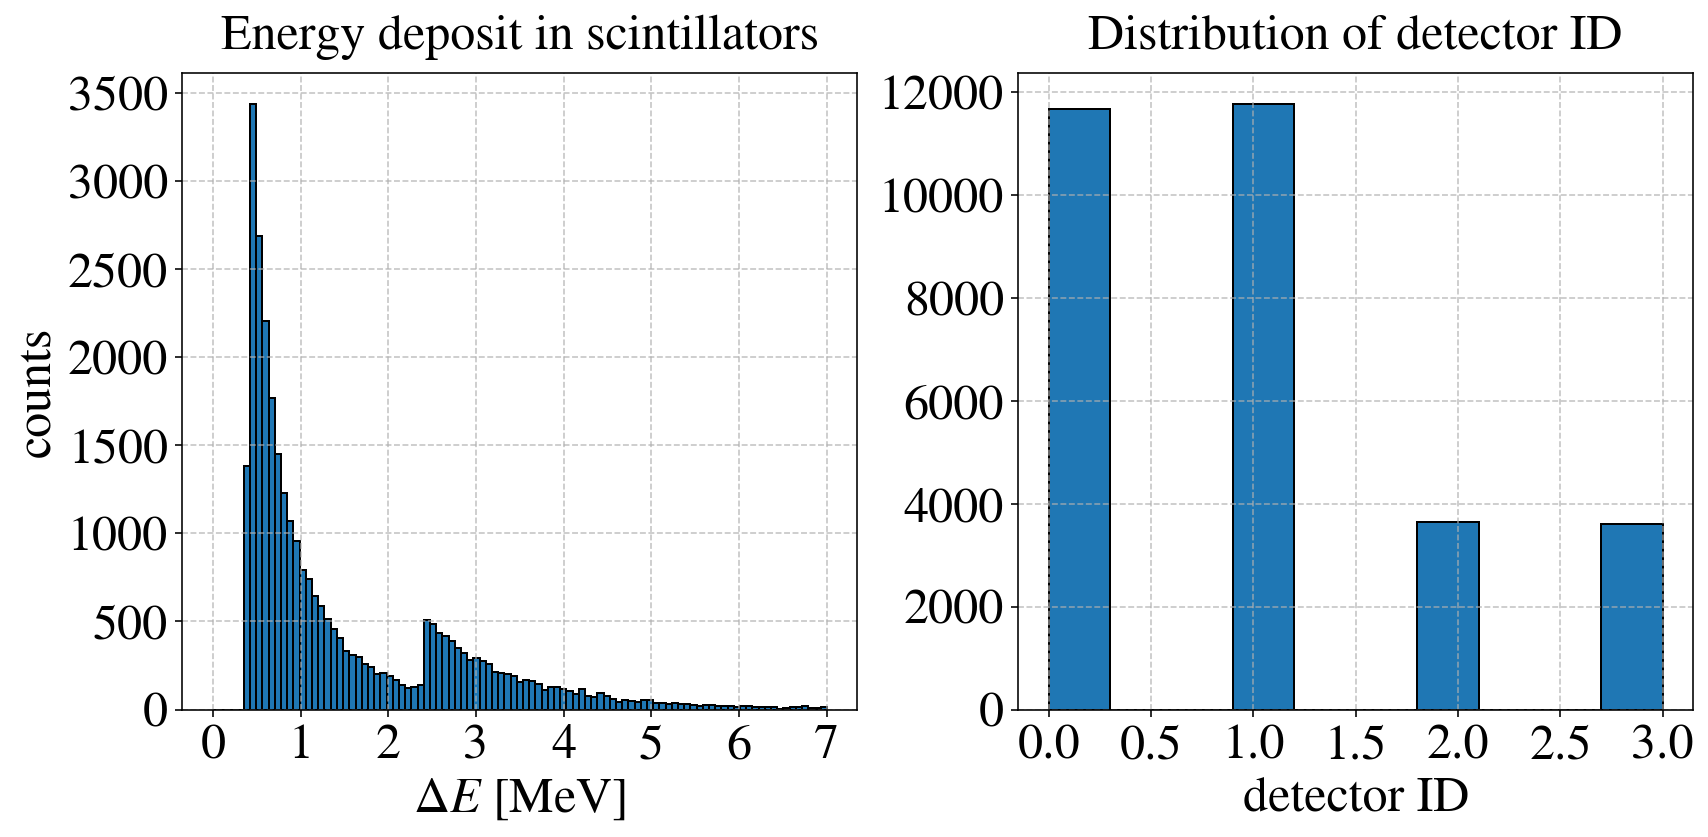

In [11]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
plt.hist(final_pulses_energy, bins=np.linspace(0,7,100), edgecolor='k')
set_axes(ax,'$\Delta E $ [MeV]','counts',title='Energy deposit in scintillators',do_add_grid=True)

ax = fig.add_subplot(1,2,2)
plt.hist(final_pulses_id, edgecolor='k')
set_axes(ax,'detector ID','',title='Distribution of detector ID',do_add_grid=True)

plt.tight_layout()

### plot Rossi-alpha

In [ ]:
# Fit a Gaussian to find the system die-away time
def dieaway_function(t,lambda_dieaway,N0,t_dieaway=1):
    
    '''
    exponential decay as a funciton of time (die-away)
    
    t_dieaway is a the time in which the correlation signal starts to decay    
    (before t_dieaway, the Rosi-alpha is independent of time since all events are correlated)    
    '''
    
    return N0*np.exp(-lambda_dieaway*(t-t_dieaway))

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

In [ ]:
fig=plt.figure(figsize=(12,8));

ax1=fig.add_subplot(1,1,1)
plt.hist( t_diff , bins=np.linspace(0,100,100), edgecolor='k',alpha=0.3);
set_axes(ax1,'dt [$\mu$s]','number of events',do_add_grid=True,xlim=(-0.1,100))

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.4,0.46,0.5,0.5])
ax2.set_axes_locator(ip)

# ax=fig.add_subplot(1,1,1)
h,bins,patches=ax2.hist( t_diff , bins=np.linspace(0,20,21),
                        label='data', edgecolor='k', 
                        alpha=0.3);

tau_dieaway        = 1 # ns
t_dieaway          = 2.5 # die-away starts after this time
t_fit              = np.linspace(t_dieaway,15,100)
lambda_dieaway     = 1./tau_dieaway;
lambda_dieaway_err = lambda_dieaway*0.05;

# lambda_PD     = 1./tau_PD;
# lambda_PD_err = lambda_PD*0.05;

N0 = h[0]
ax2.plot(t_fit,dieaway_function(t_fit,lambda_dieaway,N0,t_dieaway),'--r',linewidth=3,
         label='die-away\n$\lambda=%.2f(%.0f)$  ns$^{-1}$'%
         (lambda_dieaway,lambda_dieaway_err*100))
set_axes(ax2,'dt [ns]','',do_add_grid=True,
         xticks=(0,5,10,15,20),do_add_legend=True)
ax2.legend(fontsize=22)

# ax.set_yscale('log')
plt.tight_layout()